# マルコフ連鎖モンテカルロ法 (MCMC)
前節では解析的に事後分布の計算をした．事後分布を近似的に推論する方法の1つに**マルコフ連鎖モンテカルロ法 (Markov chain Monte Carlo methods; MCMC)** がある．他の近似推論の手法としてはLaplace近似や変分推論（variational inference）などがある．MCMCは他の手法に比して，事後分布の推論だけでなく，確率分布を神経活動で表現する方法を提供するという利点がある．

データを$X$とし，パラメータを$\theta$とする．

$$
\begin{equation}
p(\theta\mid X)=\frac{p(X\mid \theta)p(\theta)}{\int p(X\mid \theta)p(\theta)d\theta}
\end{equation}
$$

分母の積分計算$\int p(X\mid \theta)p(\theta)d\theta$が求まればよい．

### モンテカルロ法

### マルコフ連鎖


## Metropolis-Hastings法


In [1]:
using Base: @kwdef
using PyPlot, LinearAlgebra, Random, Distributions, ForwardDiff, KernelDensity, StatsBase
rc("axes.spines", top=false, right=false)

Metropolis-Hastings法における採用・不採用アルゴリズム．

In [2]:
# Metropolis-Hastings method; log_p: unnormalized log-posterior
function gaussian_mh(log_p::Function, θ_init::Vector{Float64}, σ::Float64, num_iter::Int)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        θ_ = rand(MvNormal(θ, σ*I))
        mH = log_p(θ) + logpdf(MvNormal(θ, σ*I), θ_)       # initial Hamiltonian
        mH_ = log_p(θ_) + logpdf(MvNormal(θ_, σ*I), θ)    # final Hamiltonian
        
        if min(1, exp(mH_ - mH)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

## ランジュバン・モンテカルロ法 (LMC)
拡散過程

$$
\begin{equation}
{\frac{d\theta}{dt}}=\nabla \log p (\theta)+{\sqrt 2}{d{W}}
\end{equation}
$$

Euler–Maruyama法により，

In [3]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function lmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, num_iter::Int; β=1)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    ρ = sqrt(2*ϵ);
    for m in 1:num_iter
        θ += ϵ * β * grad(θ) + ρ * randn(d)
        samples[:, m] = θ
    end
    return samples
end;

## ハミルトニアン・モンテカルロ法 (HMC法)

LMCよりも一般的なMCMCの手法としてHamiltonianモンテカルロ法(Hamiltonian Monte Calro; HMC)あるいはハイブリッド・モンテカルロ法(Hybrid Monte Calro)がある．エネルギーポテンシャルの局面上をHamilton力学に従ってパラメータを運動させることにより高速にサンプリングする手法である．

一般化座標を$\mathbf{q}$, 一般化運動量を$\mathbf{p}$とする．ポテンシャルエネルギーを$U(\mathbf{q})$としたとき，古典力学（解析力学）において保存力のみが作用する場合の**ハミルトニアン (Hamiltonian)** $\mathcal{H}(\mathbf{q}, \mathbf{p})$は

$$
\begin{equation}
\mathcal{H}(\mathbf{q}, \mathbf{p}):=U(\mathbf{q})+\frac{1}{2}\|\mathbf{p}\|^2
\end{equation}
$$

となる．このとき，次の2つの方程式が成り立つ．

$$
\begin{equation}
\frac{d\mathbf{q}}{dt}=\frac{\partial \mathcal{H}}{\partial \mathbf{p}}=\mathbf{p},\quad\frac{d\mathbf{p}}{dt}=-\frac{\partial \mathcal{H}}{\partial \mathbf{q}}=-\frac{\partial U}{\partial \mathbf{q}}
\end{equation}
$$

これを**ハミルトンの運動方程式(hamilton's equations of motion)** あるいは**正準方程式 (canonical equations)** という．



リープフロッグ(leap frog)法により離散化する．

In [4]:
function leapfrog(grad::Function, θ::Vector{Float64}, p::Vector{Float64}, ϵ::Float64, L::Int)
    for l in 1:L
        p += 0.5 * ϵ * grad(θ)
        θ += ϵ * p
        p += 0.5 * ϵ * grad(θ)
    end
    return θ, p
end;

In [5]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function hmc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, L::Int, num_iter::Int)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    num_accepted = 0
    θ = θ_init # init position
    for m in 1:num_iter
        p = randn(d) # get momentum        
        H = -log_p(θ) + 0.5 * p' * p        # initial Hamiltonian
        θ_, p_ = leapfrog(grad, θ, p, ϵ, L) # update
        H_ = -log_p(θ_) + 0.5 * p_' * p_    # final Hamiltonian
        
        if min(1, exp(H - H_)) > rand()
            θ = θ_ # accept
            num_accepted += 1
        end
        samples[:, m] = θ
    end
    return samples, num_accepted
end;

In [35]:
# Hamiltonian Monte Carlo method; log_p: unnormalized log-posterior
function almc(log_p::Function, θ_init::Vector{Float64}, ϵ::Float64, num_iter::Int; β=1)
    grad(θ)= ForwardDiff.gradient(log_p, θ)
    d = length(θ_init)
    samples = zeros(d, num_iter)
    drift_term = zeros(num_iter)
    #diff_term = zeros(num_iter)
    num_accepted = 0
    θ = θ_init # init position
    ρ = sqrt(2*ϵ);
    for m in 1:num_iter
        θ += ϵ * β * grad(θ) .* (1 .+ 10 * ρ*randn(d))
        samples[:, m] = θ
    end
    return samples
end;

## 線形回帰への適応


In [8]:
# Generate Toy datas
n_train, n_test = 50, 100 # sample size
n_iter = 10000
n_burn_in = round(Int, n_iter / 2)
dims = 4 # dimensions
σy = 0.2

polynomial_expansion(x; degree=3) = stack([x .^ p for p in 0:degree]);

Random.seed!(0);
x = rand(n_train)
y = sin.(2π*x) + σy * randn(n_train);
ϕ = polynomial_expansion(x, degree=dims-1) # design matrix

xtest = range(-0.1, 1.1, length=n_test)
ytest = sin.(2π*xtest)
ϕtest = polynomial_expansion(xtest, degree=dims-1);

In [9]:
log_joint(w, ϕ, y, σy, μ₀, Σ₀) = sum(logpdf.(Normal.(ϕ * w, σy), y)) + logpdf(MvNormal(μ₀, Σ₀), w);

In [10]:
α, β = 5e-3, 5.0

(0.005, 5.0)

In [11]:
w = randn(dims)
μ₀ = zeros(dims)
Σ₀ = 1/α * I;

In [12]:
ulp(w) = log_joint(w, ϕ, y, σy, μ₀, Σ₀)

ulp (generic function with 1 method)

In [13]:
w_init = rand(MvNormal(μ₀, Σ₀), 1)[:, 1]

4-element Vector{Float64}:
 21.63668275657154
  2.3512978351397225
  4.110944423223151
 12.557040811868173

In [36]:
#@time samples, num_accepted = hmc(ulp, w_init, 1e-2, 10, n_iter)
#@time samples = lmc(ulp, w_init, 1e-3, n_iter)
@time samples_almc = almc(ulp, w_init, 1e-3, n_iter)
#@time samples = almc2(ulp, w_init, ϕ, y, 1e-3, n_iter)

  0.063729 seconds (169.51 k allocations: 53.323 MiB, 13.85% gc time, 4.71% compilation time)


4×10000 Matrix{Float64}:
 -12.5152    9.52701  -10.2574   …   -0.274951   -0.274418   -0.275015
   2.22926  25.8114     6.07239      11.6635     11.664      11.6641
 -13.9576    0.46585  -23.0877      -33.9182    -33.9187    -33.9188
  -4.82638   2.98076   -7.21683      22.7835     22.7841     22.7844

In [15]:
#@time samples2, drift_term2, diff_term2 = lmc2(ulp, w_init, 1e-3, n_iter)

In [16]:
#@time samples = lmc(ulp, w_init, 1e-3, n_iter)

In [17]:
#ratio = diff_term ./ drift_term
#ratio2 = diff_term2 ./ drift_term2

In [18]:
#semilogy(ratio2)
#semilogy(ratio)

In [19]:
#semilogy(ratio)

In [20]:
#semilogy(diff_term)
#semilogy(diff_term2)
#axhline(1, color="tab:red")

In [21]:
#plot(samples[1, :])
#plot(samples_almc[1, :])

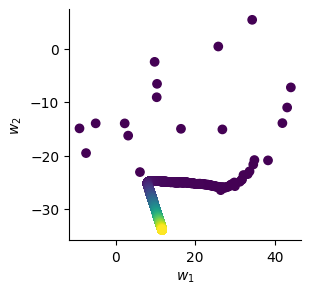

PyObject Text(24.4, 0.5, '$w_2$')

In [37]:
figure(figsize=(3,3))
scatter(samples_almc[2, :], samples_almc[3, :], c=1:n_iter)
xlabel(L"$w_1$")
ylabel(L"$w_2$")
#scatter(samples[1, :], samples[2, :], c=1:n_iter)

In [38]:
#yhmc = ϕtest * samples[:, n_burn_in:end];
yhmc = ϕtest * samples_almc[:, n_burn_in:end];
yhmc_mean = mean(yhmc, dims=2)[:];
yhmc_std = std(yhmc, dims=2)[:];

In [24]:
#error = y .- ϕ * samples;
#loss = sum(error .^ 2, dims=1)

In [39]:
error_almc = y .- ϕ * samples_almc;
loss_almc = sum(error_almc .^ 2, dims=1)

1×10000 Matrix{Float64}:
 15896.9  31958.4  16319.8  16045.3  …  2.05308  2.05301  2.05294  2.05292

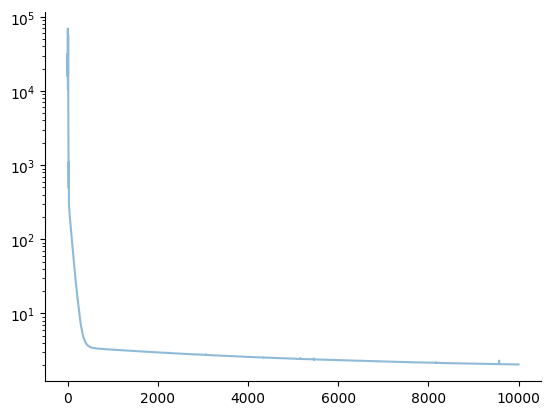

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000020198D1D850>

In [40]:
#semilogy(loss[1, :])
semilogy(loss_almc[1, :], alpha=0.5)

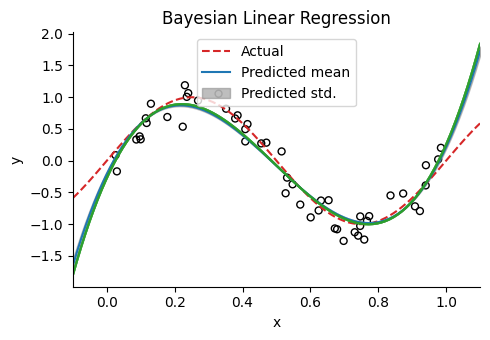

In [41]:
figure(figsize=(5,3.5))
title("Bayesian Linear Regression")
scatter(x, y, facecolor="None", edgecolors="black", s=25) # samples
plot(xtest, ytest, "--", label="Actual", color="tab:red")  # regression line
plot(xtest, yhmc_mean, label="Predicted mean", color="tab:blue")  # regression line
fill_between(xtest, yhmc_mean+yhmc_std, yhmc_mean-yhmc_std, alpha=0.5, color="tab:gray", label="Predicted std.")
for i in 1:10
    plot(xtest, yhmc[:, end-i], alpha=0.3, color="tab:green")
end
xlabel("x"); ylabel("y"); legend()
xlim(-0.1, 1.1); tight_layout()